### Entity Resolution: Identifying Real-World Entities in Noisy Data

**Fundamental theories and Python implementations**

In today's data driven world, organizations often face challenges with diverse and inconsistent data sources. Entity resolution, also called record linkage or deduplication, helps identify and merge duplicate or related records that do not share any unique identifiers within or across datasets. Accurate entity resolution improves data quality, enhances decision-making, and provides valuable insights. 

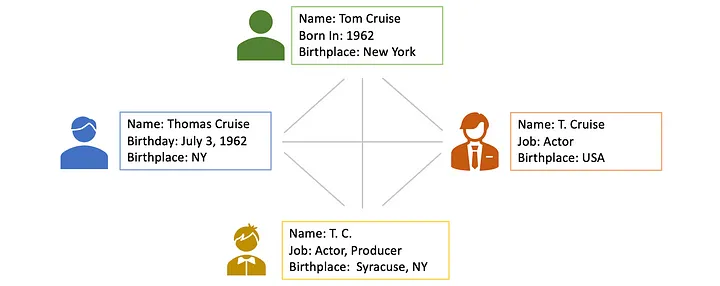

Entity resolution applies to various industries. For example, CRM systems consolidate customer information, improve service, and enable targeted marketing by resolving duplicate customer records. E-commerce platforms use entity resolution to merge product listings, enhancing search functionality, recommendations, and the customer experience. 

In this post, we will explore the technical details of fundamental entity resolution approaches using a benchmark dataset. 

### Table of Contents

* Overview of entity resolution

* Benchmark dataset

* Blocking

* Block Processing

* Entity matching

* Clustering

* Cluster Evaluation

### Overview of Entity Resolution 

The standard entity resolution (ER) framework consists of several steps: blocking, block processing, entity matching, and clustering.

1. **Blocking:** This is the first step in entity resolution and aims to reduce the search space to identify the same entity by dividing the dataset into smaller, manageable blocks. These blocks contain records that share similar attributes, making the subsequent comparison more efficient. 

2. **Block Processing:** This step refines the blocks to minimize the number of comparisons by discarding two types of unnecessary comparisons: the redundant ones, which are repeated across multiple blocks, and the superfluous ones, which involve records unlikely to match. 

3. **Entity Matching**: This focusses on comparing records within blocks to find matches based on the similarity of the records. Various similarity metrics and matching algorithms can be employed to classify pairs of records as matches or non-matches. 

4. **Clustering:** Clustering involves grouping the matched records into clusters based on their similarity. The created clusters can be used to get a consolidated view of entities. 

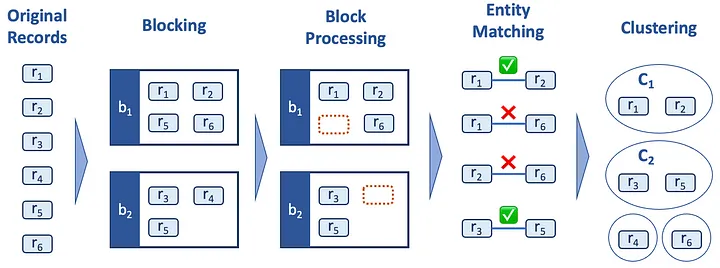

### Benchmark Dataset

In the following sections, we will dive into more details of each step in the entity resolution process, along with Python implementation using a benchmark dataset.

The dataset, sourced from the database group at the University of Leipzig and licensed with Creative Commons, is derived from actual records concerning songs from the MusicBrainz database but has been deliberately altered DAPO data pollution tool. This tool injects both duplicates and errors into the dataset, resulting in a situation where it contains duplicates for 50% of the original records in two to five sources. These duplicates have been generated with a high degree of corruption, serving as a rigorous test to evaluate the effectiveness of ER and clustering approaches. 

We can load the data with the following code:

In [1]:
import requests
from io import BytesIO
import pandas as pd
import numpy as np

url = "https://raw.githubusercontent.com/tomonori-masui/entity-resolution/main/data/musicbrainz_200k.csv"
res = requests.get(url)
df = pd.read_csv(BytesIO(res.content))

In [2]:
df.head()

TID    CID  CTID  SourceID               id number  \
0    1      1     1         1       WoM5452845      0   
1    2  32522     4         2  MBox36398328-HH     11   
2    3  53749     2         3     4382873MB-01      2   
3    4      2     1         3             unk.     17   
4    5  31368     3         4      215214-A048      6   

                                               title    length  \
0  L'enfant aux yeux d'Italie (De vous à elle en ...     03:39   
1                        Silver Forest - 双剣乱舞 みょん＆me       229   
2                            shabnavard - Chavoush 2    27.183   
3            Mustard Gas - There and Back Again Lane      2.15   
4                           006-Immer bis ich reier'  3m 48sec   

             artist                               album  year  language  
0  Daniel Balavoine  De vous à elle en passsant par moi  1975       NaN  
1               NaN       Silver Forest 2006-2012 BEST1    12  Japanese  
2       شهرام ناظری                                 NaN   NaN   Persian  
3  Action Painting!                                 NaN   '95   English  
4          Nordwand           Das Pinke Album (unknown)   NaN      Ger.

Each record represents a song having attributes such as artist, title, album, year, etc. *CID* is cluster ID and the records having the same *CID* are duplicates. Our goal is to identify those duplicates in this noisy dataset. 

To simplify our work, we are focusing only on English songs. The code below identifies records with cluster IDs that have English songs. 

In [3]:
english_cids = df[
    df.language.str.contains("^en|^eg", na=False)
].CID.unique()

df = df[df.CID.isin(english_cids)].reset_index(drop=True)
df

TID    CID  CTID  SourceID               id number  \
0        30  48502     4         2  MBox12885814-HH      2   
1       300    152     1         2   MBox6832722-HH      0   
2       534    277     1         3     2257781MB-01      1   
3      1034  36516     2         2   MBox3703407-HH      1   
4      1127    593     1         3     6505255MB-01      5   
..      ...    ...   ...       ...              ...    ...   
811  192414  82354     3         3    67575515MB-01      4   
812  192440  66336     3         5          5625310      2   
813  192698   2566     5         2  MBox33855613-HH      A   
814  192794  99495     1         3     2912968MB-01      5   
815  193081  10361     3         5          9808262      5   

                                                title  length  \
0                                 Flunk - Blue Monday     255   
1    Sixpence None the Richer - Dream Don't It's Over     243   
2                                              Ladrón     NaN   
3                         池田政典 - NIGHT OF SUMMER SIDE     249   
4                               Atlos - Vibrant Forms  10.548   
..                                                ...     ...   
811         Spellbound by a Nightmare - Dark Reveries    5.15   
812                                      lband impair     NaN   
813                           The Tights - Bad Hearts     217   
814                        Where I Belong - Invisible     4.4   
815                                     A Part of You  388213   

               artist                                              album  \
0                 NaN                               For Sleepyheads Only   
1                 NaN               The Best of Sixpence None the Richer   
2           Ttoimoshi                                             Ladrón   
3                 NaN  Kimagure Orange☆Road Eternal Collection Sound ...   
4             Fluxion                                                NaN   
..                ...                                                ...   
811          Kambrium                                                NaN   
812     kristuit salu                                         my mines i   
813               NaN                                         Bad Hearts   
814       Random Eyes                                                NaN   
815  Love of Diagrams                                    Nowhere Forever   

     year language  
0      02  English  
1      04  english  
2     NaN  english  
3     NaN  english  
4     '99  English  
..    ...      ...  
811   '13  English  
812  2002  english  
813    78  English  
814   '08  english  
815  2009   englsh  

[816 rows x 12 columns]

We are also preprocessing some of the string fields to get standardized values.

In [4]:
for col in ["title", "artist", "album"]:
    df[col] = (
        df[col].str.lower()
        .replace("[^a-z0-9]", " ", regex=True) # replacing special characters with a space
        .replace(" +", " ", regex=True) # removing consecutive spaces
        .str.strip()            # removing leading and trailing spaces
    )
    
df.loc[df.number.notna(), "number"] = (
    df[df.number.notna()]
    .number.replace("[^0-9]", "", regex=True)  # removing non-digits
    .apply(lambda x: str(int(x)) if len(x) > 0 else None) # removing leading zeros
)

Please note that this benchmark dataset is a single dataset, and if you have multiple data sources for which you want to resolve entities, you need to standardize their data schemas and consolidate these multiple data sources into a unified dataset before proceeding with the subsequent steps. 

### Blocking

Blocking is the first step in entity resolution that groups similar records together based on certain attributes. By doing so, the process narrows its search to only consider comparisons within each block, rather than examining all possible record pairs in the dataset. This significantly reduces the number of comparisons and accelerates the ER process. As it skips many comparisons, it possibly leads to missed true matches. Therefore, Blocking should achieve a good balance between efficiency and accuracy. In this section, we will explore three different blocking approaches (standard blocking, token blocking, and sorted neighborhood) to find the best balance on that trade-off. 

### Standard Blocking 

The most straightforward blocking technique involves partitioning the dataset into blocks based on a specific attribute. For example, in our dataset, one might create blocks based on *Artist* or *Title* field. This approach is intuitive and easy to implement, but its effectiveness is very sensitive to noise, as the slightest difference in the blocking keys of duplicate places them in different blocks. 

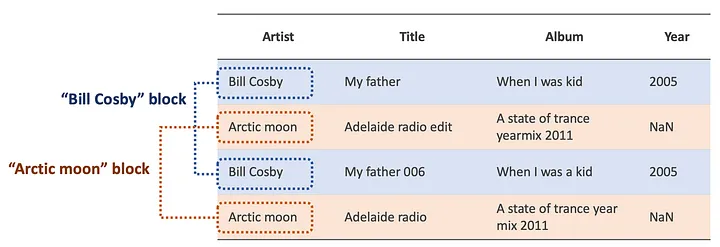

We can get standard blocks with the function below. The dictionary *blocks* will store blocking keys (*key*) and their corresponding indices (*idx*) of blocked records. 

In [5]:
from collections import defaultdict

def standard_blocking(field_values: pd.Series) -> dict[str, list]:
    blocks = defaultdict(list)
    for idx, key in enumerate(field_values):
        if key is not None:
            blocks[key].append(idx)
    return blocks

In the following code, we are creating three independent standard blocks using the fields of *title*, *artist*, and *album*.

In [6]:
sb_title = standard_blocking(df.title)
sb_artist = standard_blocking(df.artist)
sb_album = standard_blocking(df.album)

In [7]:
sb_title

defaultdict(list,
            {'flunk blue monday': [0],
             'sixpence none the richer dream don t it s over': [1],
             'ladr n': [2],
             'night of summer side': [3],
             'atlos vibrant forms': [4],
             '011 i will return': [5],
             'les huguenots act i scene 1 preludio gli ugonotti les huguenots orchestra and chorus of the teatro alla scala feat coonductor gianandrea gavazzeni disc 1': [6],
             'three kings feat slim thug t i get screwed up ikngs of the underground part 1': [7],
             'bolero': [8],
             'club bossa alternate mix without vocals': [9],
             'everyone wants to be': [10],
             'jan pieterszoon sweelinck psalm 130 du fonds de ma pens e swwv 130': [11],
             'put me back together': [12],
             '010 tenbub': [13],
             'stardust old folks wynton kelly trio with joe henderson complete recordings': [14,
              678],
             'paul flaherty simple li

### Token Blocking 

Token blocking focuses on breaking down (i.e tokenizing) the values of attributes into smaller units, called tokens, and then using these tokens to create blocks for comparison. Tokens are typically single words or small n-grams (substrings of length *n*) extracted from text. Token blocking creates a block for every distinct token value, regardless of the associated attributes: two records will be in the same block if they share a token in any of their attributes. This yields high recall, due to redundancy (i.e a single record can belong to multiple blocks), at the cost of low precision. 

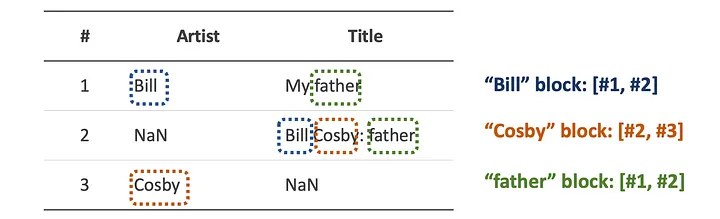

The function below generates token blocks based on word tokens. Please note we are excluding stop words (e.g. "a", "the", "is", etc.) from the tokens. 

In [8]:
from nltk.tokenize import word_tokenize

def token_blocking(df: pd.DataFrame, stop_words: set) -> dict[str, list]:
    blocks = defaultdict(list)
    for i, row in enumerate(df.itertuples()):
        # concatenate columns and tokenize
        string = " ".join([str(value) for value in row if not pd.isna(value)])
        tokens = set(
            [word for word in word_tokenize(string) if word not in stop_words]
        )
        # create words
        for token in tokens:
            blocks[token].append(i)
    return blocks

As we know which fields are relevant to create blocks, we only use specific fields (*title*, *artist*, and *album*) to perform token blocking: 

In [9]:
import string
from nltk.corpus import stopwords

columns = ['title', 'artist', 'album']
stop_words = set(stopwords.words('english') + list(string.punctuation))
token_blocks = token_blocking(df[columns], stop_words)

In [10]:
token_blocks

defaultdict(list,
            {'blue': [0,
              37,
              44,
              45,
              52,
              108,
              149,
              277,
              324,
              430,
              548,
              747,
              795],
             '0': [0],
             'flunk': [0, 44, 396, 747],
             'sleepyheads': [0, 44, 396, 430, 747],
             'monday': [0, 44, 396, 430, 747],
             'dream': [1, 214, 446],
             'richer': [1],
             'sixpence': [1],
             'best': [1,
              8,
              56,
              80,
              96,
              109,
              117,
              156,
              199,
              201,
              224,
              238,
              277,
              398,
              417,
              418,
              444,
              526,
              534,
              548,
              553,
              578,
              612,
              638,
              695

### Sorted Neighborhood

Sorted Neighborhood sorts records by specific fields' values in alphabetical order. A fixed-size window slides over the sorted records and all the possible pairs within the window are identified as candidate pairs for comparison. Please note that it directly produces a list of pairs instead of blocks. While this method effectively handles noise in blocking fields, opting for a smaller window sacrifices recall in favor of precision, whereas a larger window has higher recall with lower precision. 

<center><img src="https://raw.githubusercontent.com/tomonori-masui/entity-resolution/main/images/04_sorted_neighborhood.gif" width="750" align="center"></center>
<center>Example of Sorted Neighborhood with window size 3</center>

The code below performs Sorted Neighborhood with window size 3, using the fields of *title*, *artist* and *album* as the sorting keys. 

In [11]:
def sorted_neighborhood(
    df: pd.DataFrame, keys: list, window_size: int = 3
) -> np.ndarray:
    sorted_indices = (
        df[keys].dropna(how="all").sort_values(keys).index.tolist()
    )
    pairs = []
    for window_end in range(1, len(sorted_indices)):
        window_start = max(0, window_end - window_size)
        for i in range(window_start, window_end):
            pairs.append([sorted_indices[i], sorted_indices[window_end]])
    return np.array(pairs)

columns = ['title', 'artist', 'album']
sn_pairs = sorted_neighborhood(df, columns)

We will compare the performance of the three approaches discussed in this section after performing block processing and entity matching in the next two sections. 

### Block Processing

This step aims to improve the precision of blocks while maintaining a comparable level of recall. The relevant techniques involve reducing unnecessary and redundant comparisons within the input set of blocks *B*, resulting in generation of a new set of blocks *B* with improved precision. We will explore some of the major block-processing techniques in this section. 

### Block Purging

Block Purging sets an upper limit on the block size and purges blocks if their sizes go over the limit. It assumes that excessively large blocks are dominated by redundant comparisons, meaning that duplicates contained in those blocks are more likely to appear in other smaller blocks. 

The code below purges blocks by a predetermined limit (set as 1000 records here). It also filters out blocks with just one record as they do not create pairs to compare. We are performing this *purge_blocks* function on the three standard blocks and the token blocks from the previous section. 

In [12]:
def purge_blocks(
    blocks: dict[str, list], purging_threshold: int = 1000
) -> dict[str, list]:
    blocks_purged = {
        key:indices
        for key, indices in blocks.items()
        if len(indices) < purging_threshold and len(indices) > 1
    }
    return blocks_purged

token_blocks = purge_blocks(token_blocks)
sb_title = purge_blocks(sb_title)
sb_artist = purge_blocks(sb_artist)
sb_albums = purge_blocks(sb_album)

In [13]:
token_blocks

{'blue': [0, 37, 44, 45, 52, 108, 149, 277, 324, 430, 548, 747, 795],
 'flunk': [0, 44, 396, 747],
 'sleepyheads': [0, 44, 396, 430, 747],
 'monday': [0, 44, 396, 430, 747],
 'dream': [1, 214, 446],
 'best': [1,
  8,
  56,
  80,
  96,
  109,
  117,
  156,
  199,
  201,
  224,
  238,
  277,
  398,
  417,
  418,
  444,
  526,
  534,
  548,
  553,
  578,
  612,
  638,
  695,
  711,
  713,
  754,
  761],
 '1': [1,
  6,
  7,
  23,
  67,
  81,
  89,
  115,
  164,
  186,
  212,
  273,
  276,
  279,
  292,
  299,
  311,
  346,
  351,
  366,
  412,
  428,
  492,
  504,
  524,
  564,
  565,
  591,
  622,
  623,
  689,
  804],
 'n': [2, 250, 328, 336, 357, 457, 535, 603, 641, 646, 700, 745],
 '2': [2,
  21,
  27,
  78,
  110,
  133,
  179,
  188,
  268,
  274,
  295,
  306,
  321,
  347,
  351,
  442,
  488,
  524,
  537,
  547,
  608,
  675,
  691,
  702],
 'sound': [3,
  284,
  295,
  303,
  304,
  340,
  364,
  393,
  466,
  560,
  610,
  688,
  706,
  722,
  728],
 'collection': [3, 75, 195, 

### Meta Blocking

Meta-blocking transforms  the input block collection into a graph (or adjacency matrix), where each node corresponds to a record, and edges link every pair of records that co-occur in a block. An edge weight represents the frequency of pair occurrences across blocks: higher weights indicate a greater likelihood of a match. Edges with low weights are pruned, as they likely represent superfluous comparisons. Consequently, for each retained edge, a new block is generated, resulting in a refined block collection (or a list of pairs as each of the refined blocks only has a single pair of records). 

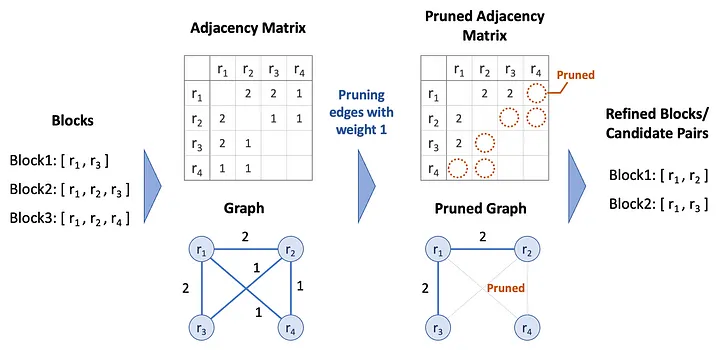

We are performing meta blocking only on token blocks as they have many overlaps across the blocks. The following code creates a list of pairs from the token blocks first and then converts it into an adjacency matrix. 

In [14]:
import itertools
from scipy.sparse import csr_matrix

def get_pairs_from_blocks(blocks: dict[str, list]) -> list[list]:
    return [
        pair
        for indices in blocks.values()
        for pair in list(itertools.combinations(indices, 2))
    ]

def get_adjacency_matrix_from_pairs(
    pairs: list[list], matrix_shape: tuple[int, int]
) -> csr_matrix:
    idx1 = [pair[0] for pair in pairs]
    idx2 = [pair[1] for pair in pairs]
    ones = np.ones(len(idx1))
    
    return csr_matrix(
        (ones, (idx1, idx2)), shape=matrix_shape, dtype=np.int8
    )

pairs = get_pairs_from_blocks(token_blocks)
adj_matrix = get_adjacency_matrix_from_pairs(pairs, (len(df), len(df)))

In [15]:
pairs

[(0, 37),
 (0, 44),
 (0, 45),
 (0, 52),
 (0, 108),
 (0, 149),
 (0, 277),
 (0, 324),
 (0, 430),
 (0, 548),
 (0, 747),
 (0, 795),
 (37, 44),
 (37, 45),
 (37, 52),
 (37, 108),
 (37, 149),
 (37, 277),
 (37, 324),
 (37, 430),
 (37, 548),
 (37, 747),
 (37, 795),
 (44, 45),
 (44, 52),
 (44, 108),
 (44, 149),
 (44, 277),
 (44, 324),
 (44, 430),
 (44, 548),
 (44, 747),
 (44, 795),
 (45, 52),
 (45, 108),
 (45, 149),
 (45, 277),
 (45, 324),
 (45, 430),
 (45, 548),
 (45, 747),
 (45, 795),
 (52, 108),
 (52, 149),
 (52, 277),
 (52, 324),
 (52, 430),
 (52, 548),
 (52, 747),
 (52, 795),
 (108, 149),
 (108, 277),
 (108, 324),
 (108, 430),
 (108, 548),
 (108, 747),
 (108, 795),
 (149, 277),
 (149, 324),
 (149, 430),
 (149, 548),
 (149, 747),
 (149, 795),
 (277, 324),
 (277, 430),
 (277, 548),
 (277, 747),
 (277, 795),
 (324, 430),
 (324, 548),
 (324, 747),
 (324, 795),
 (430, 548),
 (430, 747),
 (430, 795),
 (548, 747),
 (548, 795),
 (747, 795),
 (0, 44),
 (0, 396),
 (0, 747),
 (44, 396),
 (44, 747),
 (

In [16]:
print(adj_matrix)

  (0, 37)	1
  (0, 44)	4
  (0, 45)	1
  (0, 52)	1
  (0, 108)	1
  (0, 149)	1
  (0, 277)	1
  (0, 324)	1
  (0, 396)	3
  (0, 430)	3
  (0, 548)	1
  (0, 747)	4
  (0, 795)	1
  (1, 6)	1
  (1, 7)	1
  (1, 8)	1
  (1, 23)	1
  (1, 56)	1
  (1, 67)	1
  (1, 80)	1
  (1, 81)	1
  (1, 89)	1
  (1, 96)	1
  (1, 109)	1
  (1, 115)	1
  :	:
  (767, 792)	1
  (769, 793)	1
  (770, 791)	1
  (771, 803)	1
  (773, 791)	1
  (773, 804)	1
  (774, 802)	1
  (780, 781)	1
  (780, 790)	1
  (780, 803)	1
  (780, 808)	1
  (781, 790)	1
  (781, 808)	1
  (782, 806)	1
  (785, 794)	5
  (785, 807)	1
  (786, 797)	1
  (786, 809)	1
  (790, 808)	7
  (792, 798)	1
  (796, 800)	8
  (796, 801)	1
  (797, 802)	1
  (797, 809)	1
  (800, 801)	1


Next we are pruning edges in the adjacency matrix based on the edge weight. Here we are pruning all edges with edge weight 1, meaning pairs that only appear in a single block are trimmed. 

In [17]:
def prune_edges(
    adj_matrix: csr_matrix,
    edge_weight_threshold: float
) -> csr_matrix:
    adj_matrix_pruned = adj_matrix >= edge_weight_threshold
    return adj_matrix_pruned

adj_matrix = prune_edges(adj_matrix, edge_weight_threshold=2)

Then we get the pairs from the pruned adjacency matrix.

In [18]:
def get_pairs_from_adj_matrix(adjacency_matrix: csr_matrix) -> np.ndarray:
    return np.array(adjacency_matrix.nonzero()).T

tb_pairs = get_pairs_from_adj_matrix(adj_matrix)

print(tb_pairs)

[[  0  44]
 [  0 396]
 [  0 430]
 ...
 [785 794]
 [790 808]
 [796 800]]


### Union of Blocks

In the case of the standard blocks, we obtain a union of the three independent blocks. First, we convert the blocks into a list of adjacency matrices. 

In [19]:
adj_matrix_list = []
for blocks in [sb_title, sb_artist, sb_album]:
    pairs = get_pairs_from_blocks(blocks)
    adj_matrix_list.append(
        get_adjacency_matrix_from_pairs(pairs, (len(df), len(df)))
    )

Then we get a union of the matrices and candidate pairs from it. 

In [20]:
def get_union_of_adj_matrices(adj_matrix_list: list) -> csr_matrix:
    adj_matrix = csr_matrix(adj_matrix_list[0].shape)
    for matrix in adj_matrix_list:
        adj_matrix += matrix
    return adj_matrix

adj_matrix_union = get_union_of_adj_matrices(adj_matrix_list)
sb_pairs = get_pairs_from_adj_matrix(adj_matrix_union)

In [21]:
sb_pairs

array([[  0,   1],
       [  0,   3],
       [  0,  11],
       ...,
       [810, 811],
       [810, 814],
       [811, 814]], dtype=int32)

The table below summarizes the final number of candidate pairs from the three different blocking approaches. 

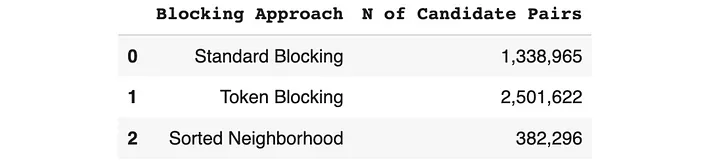!

We will determine which one is the best for our data by looking at a matching result in the next section. 

### Entity Matching

In this step, we identify matched pairs from the candidate pairs generated in the previous step. While there are various methods to find matches, one straightforward approach can be outlined as follows:

1. **Measure similarity on each attribute** 

You can use any similarity metrics such as cosine similarity, Jaccard similarity, or Levenshtein distance similarity, based on suitability for your data or specific requirements. Text fields may want to be tokenized before computing similarity for some of the metrics. 

2. **Compute overall similarity**

This step combines the per-attribute similarities into an overall similarity score either by applying manually defined rules or utilizing a machine learning model trained on labeled data if available. 

3. **Determine matches**

A similarity threshold is applied to the overall similarity score to find matches 

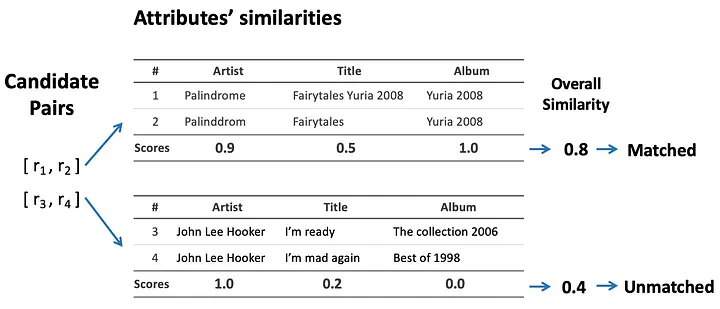

The function *get_field_similarity_scores* below takes care of the step 1 above. If *sim_type* is set to *"fuzzy"*, it calculates cosine similarity; otherwise it performs an exact match. The cosine similarity is calculated on character level 3-grams which are vectorized from input strings using the *countvectorizer* module from scikit-learn. We compute the cosine similarity for the fields of *title*, *artist* and *album* , while performing an exact match on the *number* field. 

In [22]:
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer

def get_field_similarity_scores(
    df: pd.DataFrame, pairs: np.ndarray, field_config: dict[str, str]
) -> dict[str, np.ndarray]:
    """
        Measuring similarity by field. It is either cosine similarity (if sim type == "fuzzy") 
        or exact matche 0/1 (if sim_type=="exact").
        Attribute's similarity scores are stored in field_score dictionary with the field name as key. 
    """
    field_scores = {}
    
    for field, sim_type in field_config.items():
        if sim_type == "fuzzy":
            field_scores[field] = cosine_similarities(
                df[field].fillna(""), pairs
            )
        else:
            field_scores[field] = exact_matches(df[field], pairs)
    return field_scores

def cosine_similarities(
    field_values: pd.Series, pairs: np.ndarray
) -> np.ndarray:
    """
        Computing cosine similarities on pairs
    """
    token_matrix_1, token_matrix_2 = get_token_matrix_pair(
        field_values, pairs
    )
    cos_sim = cosine_similarities_on_pair_matrices(
        token_matrix_1, token_matrix_2
    )
    return cos_sim

def get_token_matrix_pair(
    field_values: pd.Series, pairs: np.ndarray
) -> tuple[csr_matrix, csr_matrix]:
    """
        Converting pairs into matrices of token counts (matrix of records by tokens filled with token counts).
    """
    all_idx = np.unique(pairs)
    vectorizer = CountVectorizer(analyzer="char", ngram_range=(3,3))
    vectorizer.fit(field_values.loc[all_idx])
    token_matrix_1 = vectorizer.transform(field_values.loc[pairs[:,0]])
    token_matrix_2 = vectorizer.transform(field_values.loc[pairs[:,1]])
    
    return token_matrix_1, token_matrix_2

def cosine_similarities_on_pair_matrices(
    token_matrix_1: csr_matrix, token_matrix_2: csr_matrix
) -> np.ndarray:
    """
        Computing cosine similarities on pair of token count matrices. It normalizes each record (axis=1) first, then computes 
        dot product for each pair of records. 
    """
    token_matrix_1 = normalize(token_matrix_1, axis=1)
    token_matrix_2 = normalize(token_matrix_2, axis=1)
    cos_sim = np.asarray(
        token_matrix_1.multiply(token_matrix_2).sum(axis=1)
    ).flatten()
    return cos_sim

def exact_matches(
    field_values: pd.Series, pairs: np.ndarray
) -> np.ndarray:
    """
        Performing exact matches on pairs
    """
    arr1 = field_values.loc[pairs[:,0]].values
    arr2 = field_values.loc[pairs[:,1]].values
    
    return ((arr1 == arr2) & (~pd.isna(arr1)) & (~pd.isna(arr2))).astype(int)

field_config = {
    # <field>: <sim_type>
    "title": "fuzzy",
    "artist": "fuzzy",
    "album": "fuzzy",
    "number": "exact"
}

field_scores_sb = get_field_similarity_scores(df, sb_pairs, field_config)
field_scores_tb = get_field_similarity_scores(df, tb_pairs, field_config)
field_scores_sn = get_field_similarity_scores(df, sn_pairs, field_config)

In [23]:
print(field_scores_sb)
print(field_scores_tb)
print(field_scores_sn)

{'title': array([0.        , 0.        , 0.06172134, ..., 0.        , 0.        ,
       0.03504998]), 'artist': array([0., 0., 0., ..., 0., 0., 0.]), 'album': array([0.        , 0.03121953, 0.        , ..., 0.        , 0.        ,
       0.        ]), 'number': array([0, 0, 0, ..., 0, 0, 0])}
{'title': array([0.42426407, 0.51639778, 0.77459667, ..., 0.70619104, 0.5008673 ,
       0.47213369]), 'artist': array([0., 0., 0., ..., 1., 0., 1.]), 'album': array([0.        , 0.88465174, 1.        , ..., 0.        , 0.        ,
       0.        ]), 'number': array([1, 1, 1, ..., 1, 1, 1])}
{'title': array([0.18786729, 0.12171612, 0.11433239, ..., 0.        , 0.        ,
       0.        ]), 'artist': array([0.09805807, 0.        , 0.0521286 , ..., 0.        , 0.        ,
       0.        ]), 'album': array([0.        , 0.        , 0.05882353, ..., 0.        , 0.        ,
       0.        ]), 'number': array([1, 1, 1, ..., 0, 0, 0])}


### Rule Based Matching

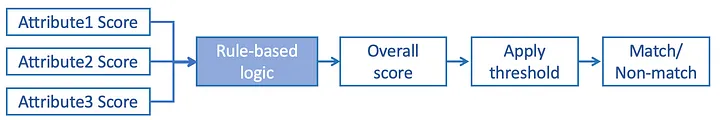

After computing field-specific similarity scores, we want to combine them into an overall similarity score, as outlined in step 2 above. We perform a very simple approach here: we just calculate the average of the attributes' scores, and subsequently, we apply a score threshold to identify matches (step 3). The threshold value below is already tuned here, but you may want to tune it by looking at some examples of matched/unmatched pairs when you work on your own dataset. 

In [24]:
def calc_overall_scores(field_scores: dict[str, np.ndarray]) -> np.ndarray:
    return np.array(list(field_scores.values())).mean(axis=0)

def find_matches(scores: np.ndarray, threshold: float) -> np.ndarray:
    return scores >= threshold

scores_sb = calc_overall_scores(field_scores_sb)
scores_tb= calc_overall_scores(field_scores_tb)
scores_sn= calc_overall_scores(field_scores_sn)
is_matched_sb = find_matches(scores_sb, threshold=0.64)
is_matched_tb= find_matches(scores_tb, threshold=0.64)
is_matched_sn = find_matches(scores_sn, threshold=0.64)
print(scores_sb, is_matched_sb)
print(scores_sn,is_matched_sn)
print(scores_tb, is_matched_tb)

[0.         0.00780488 0.01543033 ... 0.         0.         0.0087625 ] [False False False ... False False False]
[0.32148134 0.28042903 0.30632113 ... 0.         0.         0.        ] [False False False ... False False False]
[0.35606602 0.60026238 0.69364917 ... 0.67654776 0.37521683 0.61803342] [False False  True ...  True False False]


The code above performs matching on the pairs from the standard block. Additionally, we extend this matching process to the pairs from the token block and the sorted neighborhood, allowing us to compare their performances. The code below summarizes the comparison in a table.

In [25]:
from IPython.display import display
from collections import Counter

def show_results(
    is_matched_list: list[np.ndarray],
    blocking_approach_name_list: list[str]
):
    result = pd.DataFrame(
        [Counter(is_matched).values() for is_matched in is_matched_list],
        columns = ["Unmatch", "Match"]
    )
    result["Blocking Approach"] = blocking_approach_name_list
    result["Matching Rate"] = result.Match / (result.Match + result.Unmatch)
    result["Matching Rate"] = result["Matching Rate"].map("{:.1%}".format)
    result["Match"] = result["Match"].map("{:,}".format)
    result["Unmatch"] = result["Unmatch"].map("{:,}".format)
    
    display(
        result[["Blocking Approach", "Match", "Unmatch", "Matching Rate"]]
    )
    
is_matched_list = [is_matched_sb, is_matched_tb, is_matched_sn]
blocking_approach_name_list = [
    "Standard Blocking",
    "Token Blocking",
    "Sorted Neighborhood"
]

show_results(is_matched_list, blocking_approach_name_list)

Blocking Approach Match Unmatch Matching Rate
0    Standard Blocking   499  28,165          1.7%
1       Token Blocking   570     882         39.3%
2  Sorted Neighborhood   222   2,220          9.1%

As you can see in the table, Token Blocking yields the highest number of matches, while also having highest matching rate. As token blocking likely has the fewest missed matches, we will proceed with the outcome from this approach. It is worth noting that our small dataset does not present scalability concerns. However, for large datasets where Token Blocking may not be feasible, you may want to consider the other more scalable approaches. 

### Machine-Learning Matching

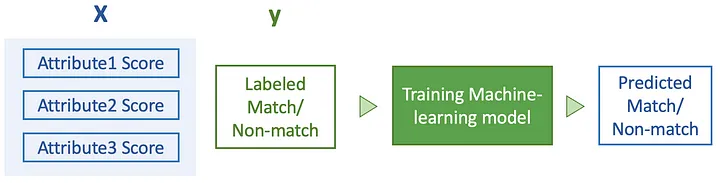

If you have labeled data or have manually labeled sample pairs as matches or non-matches, you can train a machine-learning model to predict matched pairs. As our data has cluter labels *CID*, we will convert these into matching labels (match/unmatch) for pairs and train a machine-learning model, subsequently comparing its performance with the rule-based approach performed in the previous section.

The following code generates the model input *X* and the corresponding target variable *y*. Pairs within the same cluster *CID* are designated as matches (y = 1), while pairs outside the same cluster are labeled as non-matches (y = 0).

In [26]:
def get_x_y(
    field_scores: dict[str, np.ndarray],
    pairs: np.ndarray,
    df: pd.DataFrame
) -> tuple[pd.DataFrame, np.ndarray]:
    X = pd.DataFrame(field_scores)
    y = df.loc[pairs[:,0], "CID"].values == df.loc[pairs[:, 1], "CID"].values
    return X, y

X, y = get_x_y(field_scores_tb, tb_pairs, df)
X, y

(         title  artist     album  number
 0     0.424264     0.0  0.000000       1
 1     0.516398     0.0  0.884652       1
 2     0.774597     0.0  1.000000       1
 3     0.424264     0.0  1.000000       1
 4     0.000000     0.0  0.000000       0
 ...        ...     ...       ...     ...
 1447  1.000000     1.0  0.000000       1
 1448  0.676123     1.0  0.784465       1
 1449  0.706191     1.0  0.000000       1
 1450  0.500867     0.0  0.000000       1
 1451  0.472134     1.0  0.000000       1
 
 [1452 rows x 4 columns],
 array([ True,  True,  True, ...,  True,  True,  True]))

Next, we split them into training and testing sets, followed by training a logistic regression model. 

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.5, random_state = 42
)
model = LogisticRegression(random_state=0).fit(X_train, y_train)

The code below compares its performance (*f1 score*) with the rule-based approach. 

In [28]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)
print(f"Model f1_score: {f1_score(y_test, y_pred):.3f}")

y_rule_base = is_matched_tb[X_test.index.values]
print(f"Rule-base f1_score: {f1_score(y_test, y_rule_base):.3f}")

Model f1_score: 0.978
Rule-base f1_score: 0.742


While the model performance is better, the performance of the rule-based approach may still be reasonably good. 

For the following steps, we will use matches identified through the rule-based approach, considering that in many real-world cases, manual data labeling might not be practical due to resource constraints. The code below extracts matched pairs and their similarity scores from the candidate pairs and their scores on token blocking. 

In [29]:
matched_pairs = tb_pairs[is_matched_tb]
matched_scores = scores_tb[is_matched_tb]
print(matched_pairs, matched_scores)

[[  0 430]
 [  6 276]
 [  6 311]
 ...
 [755 778]
 [766 812]
 [785 794]] [0.69364917 0.64969624 0.74603175 0.64969624 0.73877516 0.91398401
 0.65365907 0.88962131 0.83574929 0.89635421 0.96217124 0.71088185
 0.69881405 0.94263986 0.88656329 0.65039478 0.94469804 0.87042586
 0.86547005 0.65009575 0.75       0.8283447  0.80504209 0.937393
 0.70623948 0.7180204  0.90590239 0.70833333 0.82048322 0.7192645
 0.75       0.66740462 0.70264366 0.68670401 0.97088295 0.66413304
 0.6767767  0.66279559 0.6767767  0.75       0.66366342 0.91366342
 0.66289594 0.81521719 0.73360344 0.71197245 0.85727402 0.72996655
 0.84910775 0.92654636 0.75       0.66666667 0.66666667 0.67860863
 0.80498097 0.75510836 0.6767767  0.68969673 0.9267767  0.93227837
 0.75       0.74895654 0.79595952 0.75       0.69989802 0.89109283
 0.75       0.71194781 0.75       0.72321429 0.71462588 0.93274054
 0.75       0.90309311 0.86892082 0.91189016 0.8224807  0.70302589
 0.70189929 0.84092573 0.90495766 0.84757868 1.         0.93

### Clustering

In this step, we are creating entity clusters based on the matched pairs from the previous step. Each cluster includes all records corresponding to a distinct real-world entity. 

Clustering for entity resolution has several requirements:

1. **Unconstrained algorithm**: The algorithms should not require any domain specific parameters as input, such as the number of clusters or the diameter of the clusters. 

2. **Capability of handling an incomplete similarity matrix**: As the entity resolution process does not compute similarity on every possible pair (which could be described as an N by N matrix), the algorithms must be able to handle an incomplete similarity matrix (or a list of matched pairs.)

3. **Scalability**: Entity resolution often handles sizable datasets, making it important that algorithms are capable of handling such data. In case of large data, algorithms having high complexity like hierarchial clustering might not be practical. 

For the clustering, we will examine three major single-pass clustering algorithms: Partitioning (i.e connected components), Center Clustering, and Merge-Center Clustering , all of which satisfy the requirements. These algorithms are highly efficient as they create clusters by a single scan (or O(n) time complexity) of the list of candidate pairs, although some of them require the list to be sorted by similarity score. 

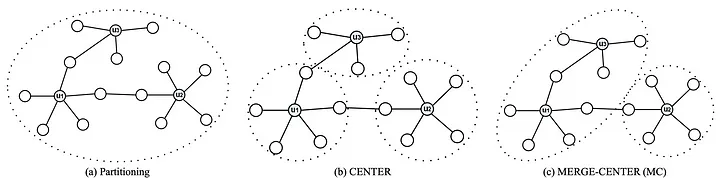

### Partitioning/Connected Components

This algorithm initiates clustering by initially assigning each node to its individual cluster. Then, it conducts a single scan of the list of matched pairs. If it identifies connected nodes that do not belong to the same cluster, it merges their clusters. In short, it forms a cluster by grouping all the connected nodes via edges (i.e. matched records via pairs). The algorithm may create clusters that connect dissimilar records via long paths.

Connected components clustering can be performed using the Scipy module as you can see in the code below. Before performing it, you want to convert the list of pairs into an adjacency matrix. 

In [30]:
from scipy.sparse.csgraph import connected_components

def connected_components_from_pairs(
    pairs: np.ndarray, dim: int
) -> np.ndarray :
    adjacency_matrix = get_adjacency_matrix_from_pairs(pairs, (dim, dim))
    _, clusters = connected_components(
        csgraph = adjacency_matrix, directed=False, return_labels=True
    )
    return clusters

cc_clusters = connected_components_from_pairs(matched_pairs, len(df))

In [31]:
cc_clusters

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  21,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,   0,  36,  43,  41,  44,  45,  46,  47,
        36,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  56,
        59,  60,  61,  62,  63,  31,  64,  65,  66,  67,  68,  69,  70,
        21,  71,   8,  72,  73,  67,  74,  75,  76,  50,  77,   7,  78,
        78,  35,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  36,  82,  94,  57,  55,  95,  96,  97,  98,
        99,  54, 100, 101,  71,  12, 102, 103, 104, 105, 106, 107, 108,
        48,  13, 109,  21, 110, 111, 112,  43,  70,  17, 113, 114, 115,
        81,  53, 116, 117, 118,  44, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130,  17, 131, 132, 133, 117, 134, 135, 136,
       137, 138,  80,  55, 139,  19, 140, 141, 137, 142, 143, 11

### Center Clustering

This algorithm performs clustering where each cluster has a center and all records in each cluster are similar to the center of the cluster. It requires the list of similar pairs to be sorted by descending order of similarity scores. This algorithm then performs clustering by a single scan of the sorted list. When a node *u* is encountered for the first time in the scan, it's designated as the cluster center. Any subsequent nodes *v* that are similar to *u* (i.e appear in a pair *(u,v)* in the list) are assigned to the cluster of *u* and are not considered again during the process. 

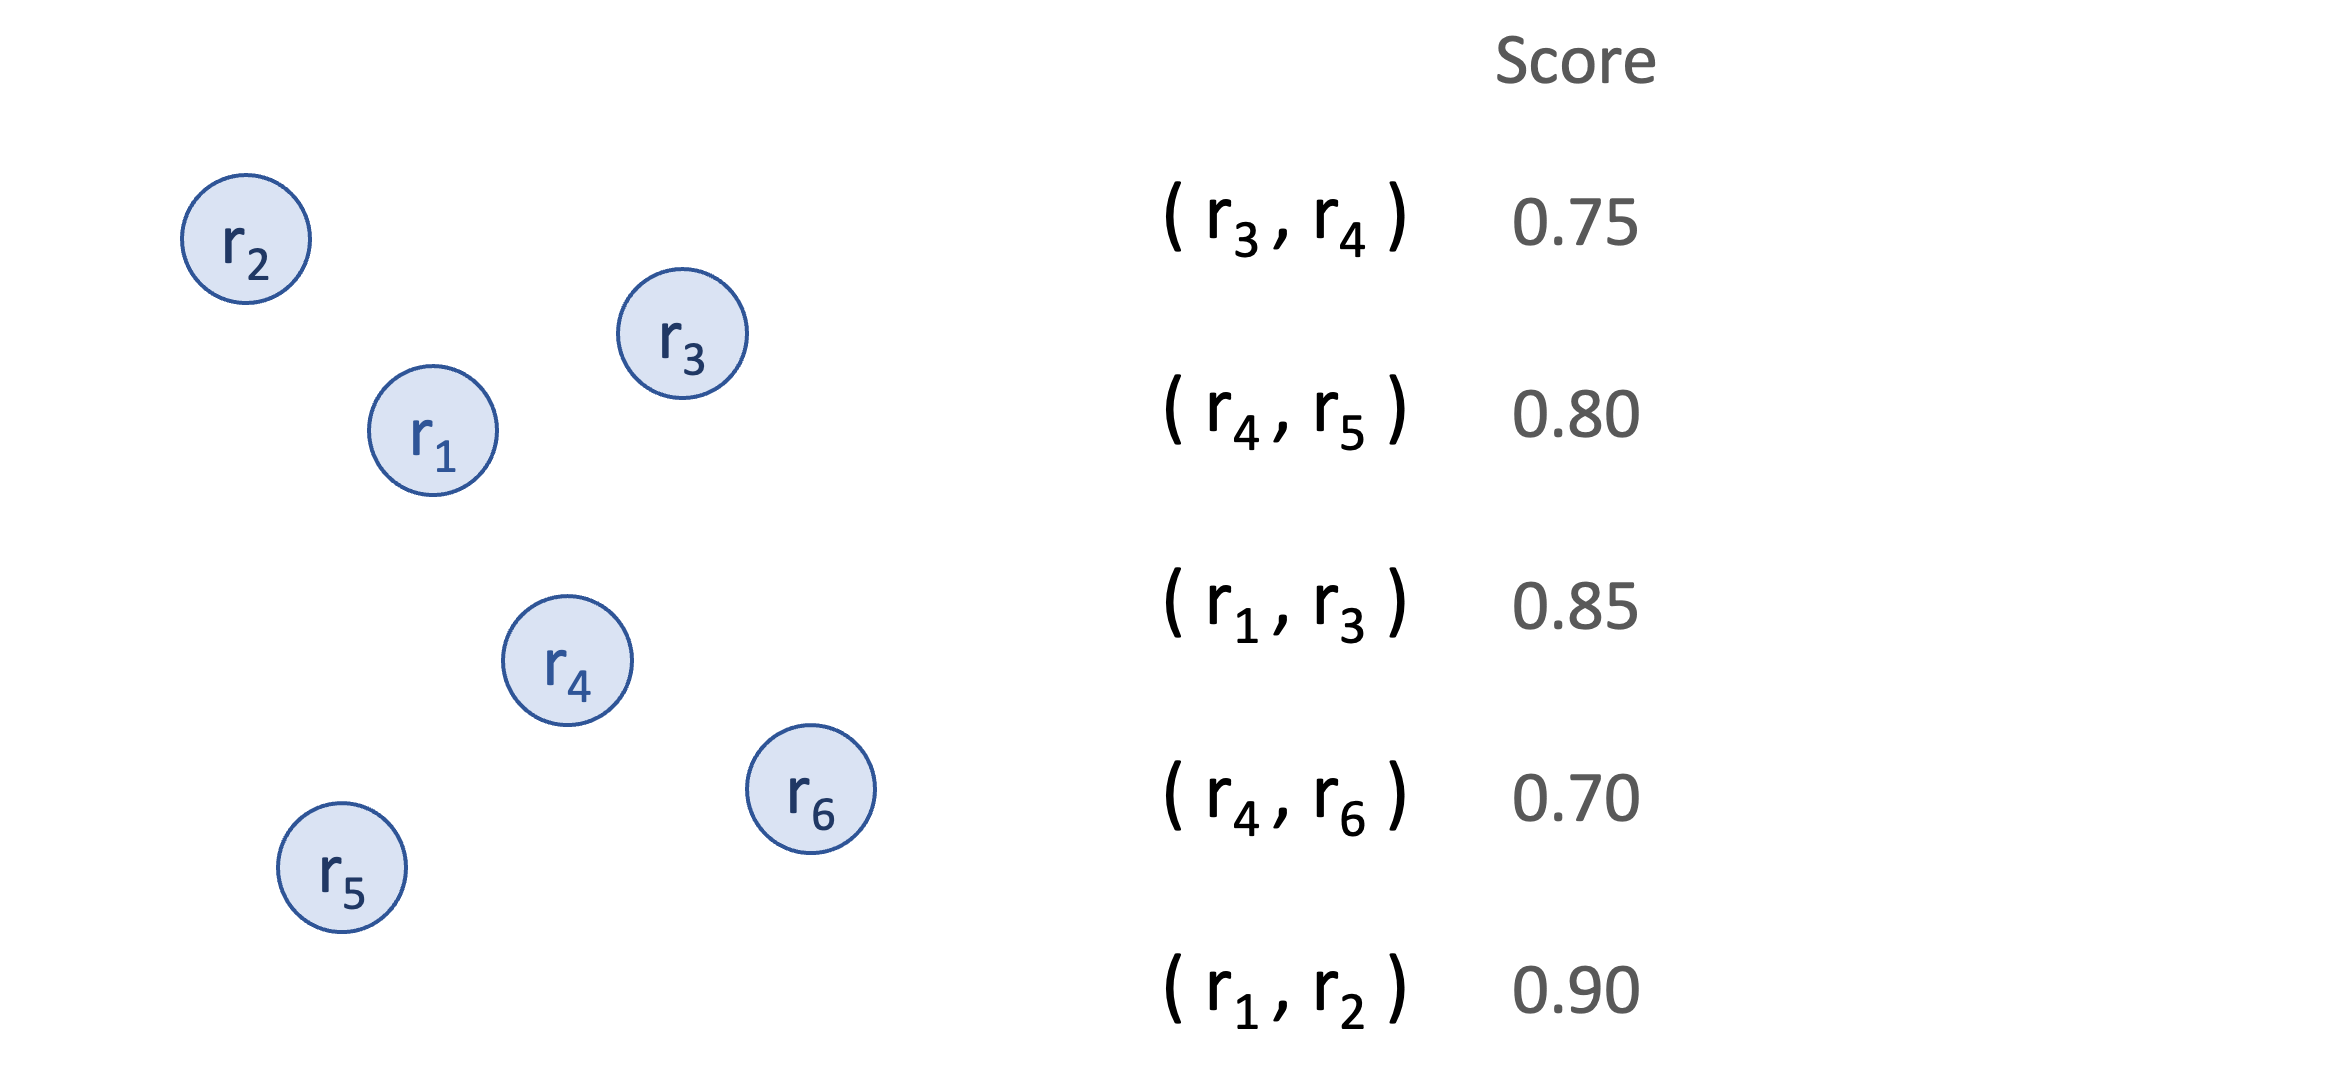

### Merge-Center Clustering 

This algorithm performs similarly to Center Clustering, but merges two clusters c_i and c_j whenever a record that is similar to the center of the cluster c_i is similar to the center of c_j. Note that when two clusters are merged, it does not choose a single center node, which means that merged clusters can have multiple center nodes. This algorithm can be performed similarly by a single scan of the list of similar pairs, but by keeping track of the records that are connected through a merged cluster. 

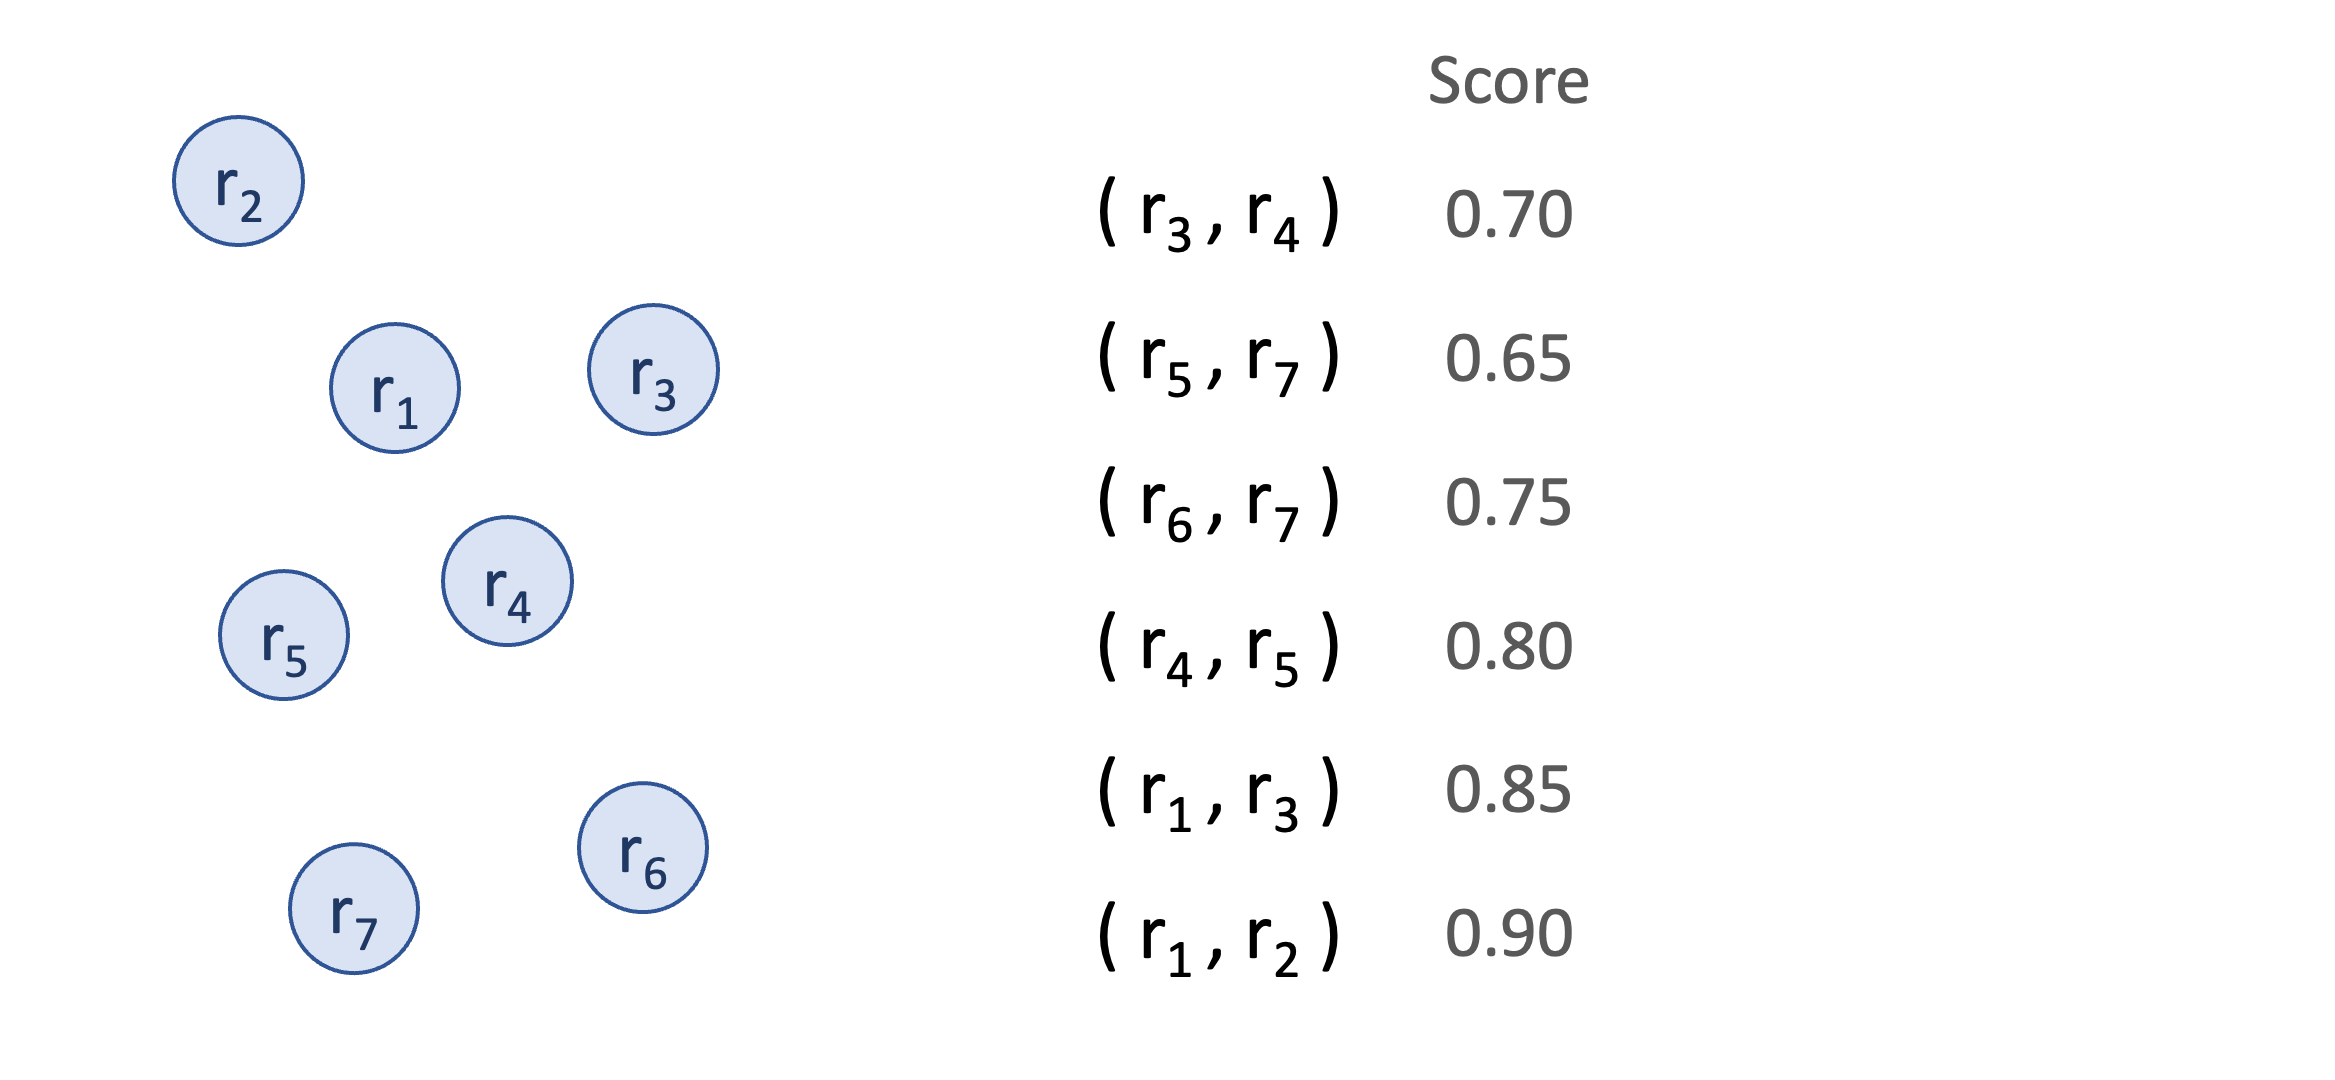

To perform Center/Merge-Center clustering, we first need to sort the list of pairs by descending order of the similarity scores. 

In [32]:
def sort_pairs(pairs: np.ndarray, scores: np.ndarray) -> np.ndarray:
    sorted_ids = (-1 * scores).argsort()
    return pairs[sorted_ids]

pairs_sored = sort_pairs(matched_pairs, matched_scores)
pairs_sored

array([[362, 368],
       [ 95, 483],
       [212, 412],
       ...,
       [239, 480],
       [584, 757],
       [518, 613]], dtype=int32)

Next, the code below yields two sets of pairs: center-child pairs, denoted as *center_cluster_pairs*, and merged node pairs, referred to as *merge_cluster_pairs*. We can then generate Center Clusters and Merge-Center clusters by applying connected components to these list of pairs. 

In [34]:
def get_center_cluster_pairs(pairs, dim):
    """
        cluster_centers:
            a list tracking cluster center for each record.
            Indices of the list correspond to the original df indices
            and the values represent assigned cluster centers' indices 
        cluster_center_pairs: 
            a list of pairs of indices representing center-child pairs 
        merge_cluster_pairs:
            a list of pairs of merged nodes' indices 
    """
    cluster_centers = [None] * dim
    center_cluster_pairs = []
    merge_cluster_pairs = []
    
    for idx1, idx2 in pairs:
        
        if (
            cluster_centers[idx1] is None or
            cluster_centers[idx1] == idx1 or
            cluster_centers[idx2] is None or 
            cluster_centers[idx2] == idx2
        ):
            # if both aren't child , those nodes are merged
            merge_cluster_pairs.append([idx1, idx2])
            
        if cluster_centers[idx1] is None and cluster_centers[idx2] is None:
            # if both weren't seen before, idx1 becomes center and idx2 gets child
            cluster_centers[idx1] = idx1
            cluster_centers[idx2] = idx1
            center_cluster_pairs.append([idx1, idx2])
        elif cluster_centers[idx2] is None:
            if cluster_centers[idx1] == idx1:
                # if idx1 is center, idx2 is assigned to that cluster
                cluster_centers[idx2] = idx1
                center_cluster_pairs.append([idx1, idx2])
            else:
                # if idx1 is not center, idx2 becomes new center
                cluster_centers[idx2] = idx2
        elif cluster_centers[idx1] is None:
            if cluster_centers[idx2] == idx2:
                # if idx2 is center, idx1 is assigned to that cluster
                cluster_centers[idx1] = idx2
                center_cluster_pairs.append([idx1, idx2])
            else:
                # if idx2 is not center, idx1 becomes new center
                cluster_centers[idx1] = idx1
                
    return center_cluster_pairs, merge_cluster_pairs

center_cluster_pairs, merge_cluster_pairs = get_center_cluster_pairs(pairs_sored, len(df))
ct_clusters = connected_components_from_pairs(center_cluster_pairs, len(df))
mc_clusters = connected_components_from_pairs(merge_cluster_pairs, len(df))

### Cluster Evaluation

As we have the cluster labels, we can evaluate the quality of the clusters using *Rand Index* or *adjusted Rand Index*. Rand Index is a cluster evaluation metric that represents the proportion of pairs that are correctly clustered together or apart. It is defined as follows:

*TP = Number of pairs that are clustered **together** in both predicted and true clusters.*

*TN = Number of pairs that are clustered **apart** in both predicted and true clusters.*

***Rand Index**: (TP + TN)/Total number of possible pairs.*

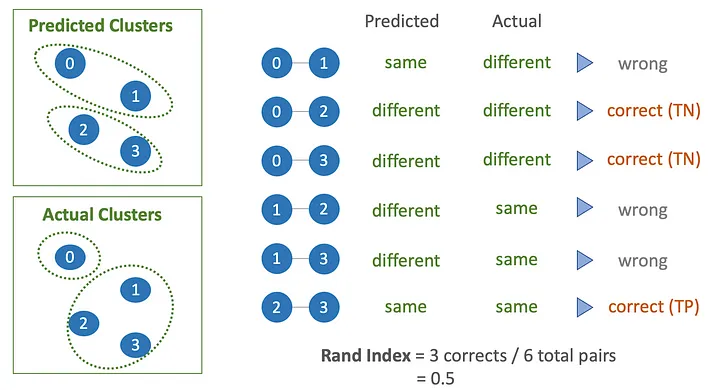

Adjusted Rand Index is a modified version of Rand Index that is corrected for chance. The adjustment accounts for the possibility of random agreement from clustering results that were randomly assigned. 

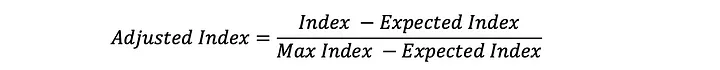

The author would not delve into how each term in the above equation is calculated here, but anyone who is interested in this topic can refer to the paper from KY Yeung which explains the metric with some examples. 

The code below gives us a comparison of the clusters using those metrics along with some additional basic statistics. 

In [36]:
from sklearn.metrics.cluster import rand_score, adjusted_rand_score
from IPython.display import display

def get_stats(labels, clusters):
    stats = []
    stats.append(f"{rand_score(labels, clusters): .3f}")
    stats.append(f"{adjusted_rand_score(labels, clusters):.3f}")
    clus_dist = pd.Series(clusters).value_counts()
    stats.append(f"{len(clus_dist):,}")
    stats.append(f"{clus_dist.mean():.3f}")
    stats.append(f"{clus_dist.min():,}")
    stats.append(f"{clus_dist.max():,}")
    
    return stats

def compare_clusters(cluster_list, cluster_names, labels):
    stats_dict = {}
    for clusters, name in zip(cluster_list, cluster_names):
        stats = get_stats(labels, clusters)
        stats_dict[name] = stats
        
    display(
        pd.DataFrame(
            stats_dict,
            index = [
                "Rand Index",
                "Adjusted Rand Index",
                "Cluster Count",
                "Mean Cluster Size",
                "Min Cluster Size",
                "Max Cluster Size"
            ]
        )
    )
    
cluster_list = [cc_clusters, ct_clusters, mc_clusters]
cluster_names = ["Connected Components", "Center", "Merge-Center"]
compare_clusters(cluster_list, cluster_names, df.CID)

Connected Components  Center Merge-Center
Rand Index                         0.999   0.998        0.999
Adjusted Rand Index                0.858   0.558        0.858
Cluster Count                        434     545          434
Mean Cluster Size                  1.880   1.497        1.880
Min Cluster Size                       1       1            1
Max Cluster Size                       5       5            5

As we can see in the table above, connected components and merge-center components produce the largest clusters with the fewest cluster count. Conversely, the Center clusters yield the smaller clusters with the highest count. Please note that all three clusters have very high Rand Index , as they have large number of clusters making inter-cluster pairs dominant (ie. even random clustering yields a respectable Rand Index). However, if you look at the Adjusted Rand Index, Merge Center Clustering is the best, while its difference from connected components is marginal. 

That concludes this exploration by the author (**Tomonuri Masui**) of the entity resolution framework. How we proceed with the created clusters depend on our specific business requirements or use case. If we aim to establish a canonical representation for each cluster, we can achieve this by extracting the most representative value (such as the most frequent value) for each field within each cluster. 